## Fourier Transform vs Fourier Series Analysis

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.optimize import curve_fit

# Generate time array
t = np.linspace(0, 4, 1000)

# Trend component (linear trend)
trend = 0.5 * t

# Complex seasonality component
def complex_seasonality(t):
    # Multiple sinusoidal components with different frequencies and amplitudes
    s1 = 2 * np.sin(2 * np.pi * t)  # Annual cycle
    s2 = 1.5 * np.sin(4 * np.pi * t)  # Semi-annual cycle
    s3 = 0.7 * np.sin(8 * np.pi * t)  # Quarterly cycle
    s4 = 0.3 * np.sin(16 * np.pi * t)  # Monthly cycle
    
    # Non-sinusoidal component (e.g., sawtooth wave for a sharp recurring pattern)
    s5 = 0.5 * (t % 1)
    
    # Exponential decay to simulate diminishing effect
    s6 = 0.5 * np.exp(-t) * np.sin(12 * np.pi * t)
    
    # Combine all components
    return s1 + s2 + s3 + s4 + s5 + s6

# Generate complex seasonality
seasonality = complex_seasonality(t)

# Noise component (you can adjust the standard deviation to increase/decrease noise)
noise = np.random.normal(0, 0.3, 1000)

# Combine all components
y = trend + seasonality + noise

In [10]:
# Fourier Series Approach (simplified)
def fourier_series(t, a0, a1, b1, a2, b2):
    return a0 + a1 * np.cos(2 * np.pi * t) + b1 * np.sin(2 * np.pi * t) + \
           a2 * np.cos(4 * np.pi * t) + b2 * np.sin(4 * np.pi * t)

popt, _ = curve_fit(fourier_series, t, y - trend)

In [13]:
# Function to filter out noise (keep top k frequencies)
def filter_frequencies(fft_result, k):
    sorted_indices = np.argsort(np.abs(fft_result))[::-1]
    top_k_indices = sorted_indices[:k]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_k_indices] = fft_result[top_k_indices]
    return filtered_fft

# Assuming 't' and 'y' are your time and data arrays
# Fourier Transform Approach
trend = 0.5 * t  # Assuming linear trend, adjust if needed
y_detrended = y - trend
fft_result = fft(y_detrended)
frequencies = np.fft.fftfreq(len(t), t[1] - t[0])

# Filter and reconstruct the signal
filtered_fft = filter_frequencies(fft_result, k=5)
reconstructed_y = np.real(ifft(filtered_fft))

# Add back the trend
fft_forecast = reconstructed_y + trend

# Now fft_forecast contains the FFT-based reconstruction for the training data

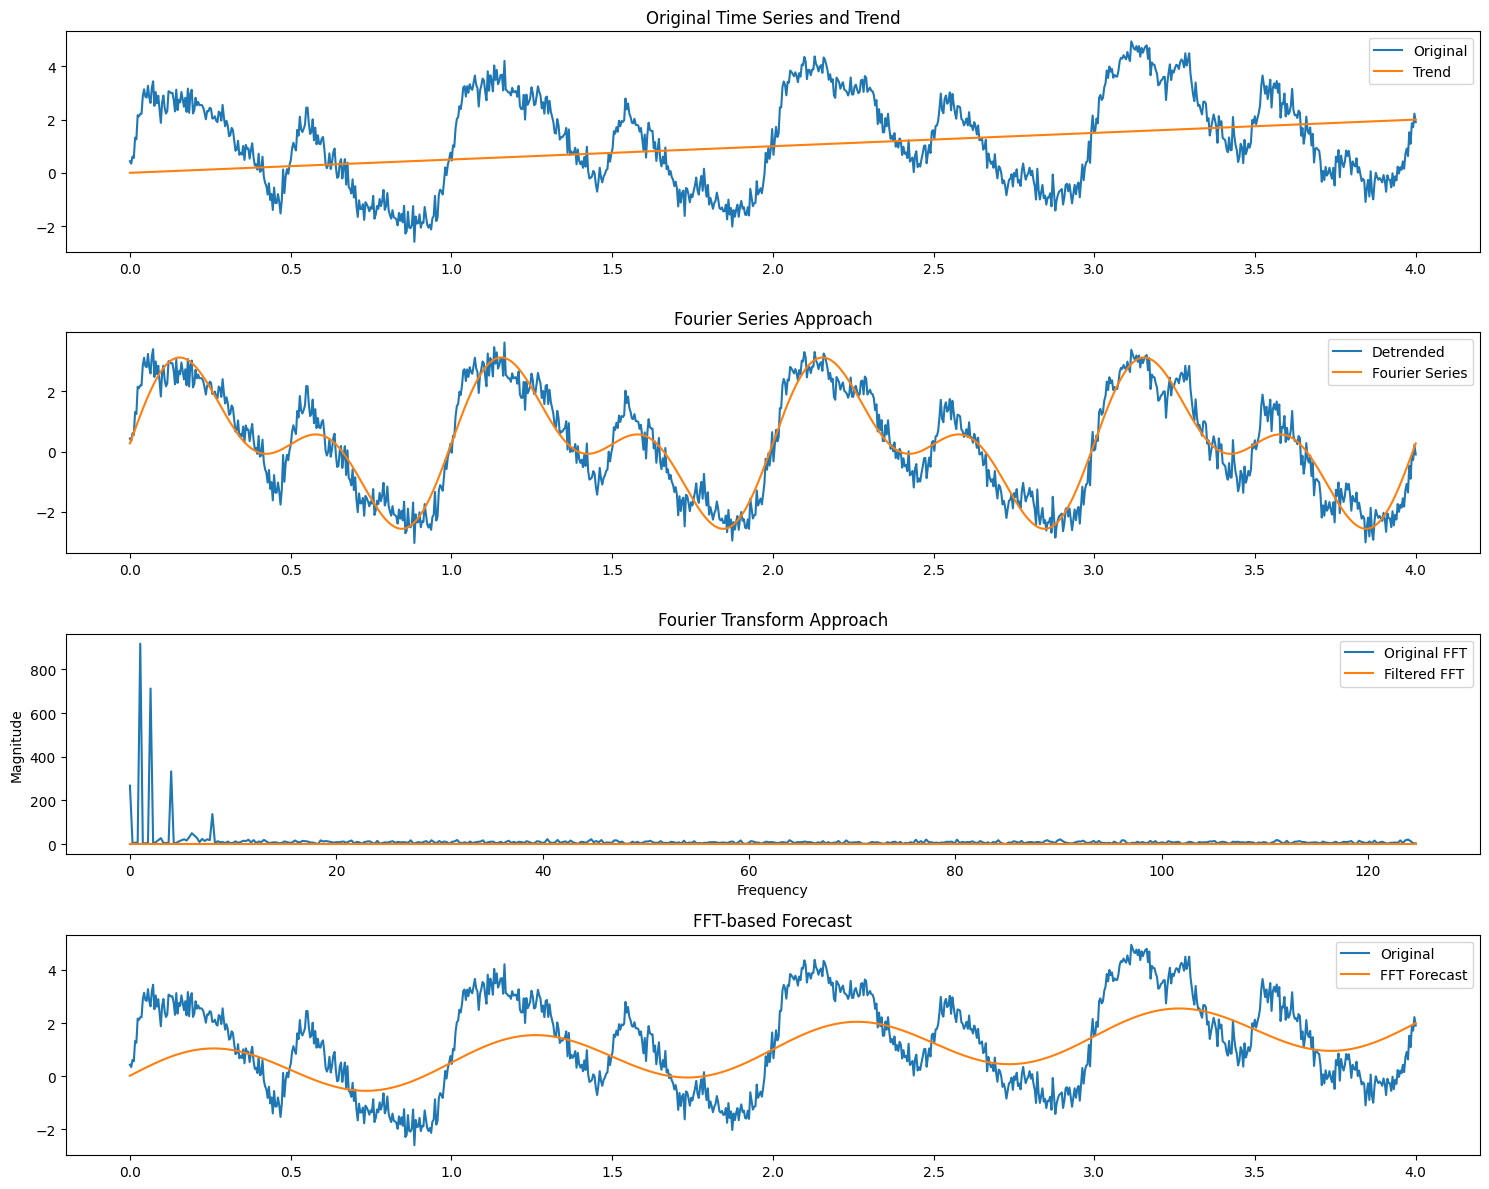

In [14]:
# Plot results
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(t, y, label='Original')
plt.plot(t, trend, label='Trend')
plt.legend()
plt.title('Original Time Series and Trend')

plt.subplot(4, 1, 2)
plt.plot(t, y_detrended, label='Detrended')
plt.plot(t, fourier_series(t, *popt), label='Fourier Series')
plt.legend()
plt.title('Fourier Series Approach')

plt.subplot(4, 1, 3)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2], label='Original FFT')
plt.plot(frequencies[:len(frequencies)//2], np.abs(filtered_fft)[:len(frequencies)//2], label='Filtered FFT')
plt.legend()
plt.title('Fourier Transform Approach')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.subplot(4, 1, 4)
plt.plot(t, y, label='Original')
plt.plot(t, fft_forecast, label='FFT Forecast')
plt.legend()
plt.title('FFT-based Forecast')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Generate a time series with trend, seasonality, and noise
t = np.linspace(0, 4, 1000)
trend = 5 + 0.5 * t + 0.05 * t**2  # Non-linear trend, shifted up to ensure positivity
seasonality = 2 * np.sin(2 * np.pi * t) + np.sin(4 * np.pi * t)
noise = np.random.normal(0, 0.5, 1000)
y = trend + seasonality + noise

def phase_corrected_fft_forecast(y, t, forecast_horizon):
    # Estimate and remove trend
    model = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=250)
    result = model.fit()
    trend = result.trend
    y_detrended = y - trend

    # Perform FFT on detrended data
    n = len(t)
    fft_result = fft(y_detrended)
    frequencies = np.fft.fftfreq(n, t[1] - t[0])

    # Find peaks in the frequency spectrum
    peaks, _ = find_peaks(np.abs(fft_result[:n//2]), height=np.std(np.abs(fft_result)))
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[peaks] = fft_result[peaks]
    filtered_fft[-peaks] = fft_result[-peaks]

    # Reconstruct the seasonal component
    seasonal = np.real(ifft(filtered_fft))

    # Ensure phase alignment
    seasonal_forecast = np.tile(seasonal, 2)[:n+forecast_horizon]
    phase_shift = np.argmin(np.abs(seasonal_forecast[n-1] - seasonal_forecast[n:n+50]))
    seasonal_forecast = np.roll(seasonal_forecast, -phase_shift)[n:n+forecast_horizon]

    # Forecast trend
    trend_forecast = result.forecast(forecast_horizon)

    # Combine forecasts
    forecast = trend_forecast + seasonal_forecast

    return forecast, trend, seasonal

# Perform forecasting
forecast_horizon = 200
forecast, trend, seasonal = phase_corrected_fft_forecast(y, t, forecast_horizon)

# Prepare data for plotting
extended_t = np.linspace(0, 4 + 4*forecast_horizon/1000, 1000 + forecast_horizon)

# Plot results
plt.figure(figsize=(15, 10))

plt.plot(t, y, label='Original', alpha=0.7)
plt.plot(extended_t[1000:], forecast, label='FFT Forecast', color='red')
plt.axvline(x=4, color='green', linestyle='--', label='Forecast Start')
plt.legend()
plt.title('Original Time Series and Phase-Corrected FFT-based Forecast')
plt.xlabel('Time')
plt.ylabel('Value')

plt.tight_layout()
plt.show()